In [74]:
import numpy as np
import networkx as nx
from functools import partial

from qokit.qaoa_circuit_maxcut import get_qaoa_circuit
from qokit.maxcut import maxcut_obj, get_adjacency_matrix
from qokit.utils import brute_force, objective_from_counts, invert_counts
from qokit.parameter_utils import get_fixed_gamma_beta

# Scipy results
from scipy.optimize import minimize

from qokit.qaoa_objective_maxcut import get_qaoa_maxcut_objective
from qokit.utils import precompute_energies

In [102]:
# Generate a random regular graph
N = 14
d = 3
seed = 1
G = nx.random_regular_graph(d, N, seed=seed)

# Generate random angles
gamma = np.random.uniform(-np.pi, np.pi, N)
beta = np.random.uniform(-np.pi, np.pi, N)

p = 11
# Get circuit
qc = get_qaoa_circuit(G, gamma, beta, save_statevector=False)
qc.measure_all()

# Get the optimal cut
obj = partial(maxcut_obj, w=get_adjacency_matrix(G))
optimal_cut = brute_force(obj, N, function_takes="bits")

In [103]:
def random_init(p):
    gamma = np.random.uniform(-np.pi, np.pi, p)
    beta = np.random.uniform(-np.pi, np.pi, p)
    return np.hstack([gamma, beta])

def fixed_angles_init(p):
    gamma = np.full(p, -0.2)
    beta = np.full(p, 0.2)
    return np.hstack([gamma, beta])

def tqa_init(p, delta_t=0.5):
    """
    Initialize QAOA parameters using the TQA (Trotterized Quantum Annealing) heuristic.
    
    Parameters:
        p (int): The number of QAOA layers.
        delta_t (float): The total time parameter for the annealing schedule.
    
    Returns:
        np.ndarray: The initial QAOA parameters (concatenation of gamma and beta values).
    """
    # Compute gamma values based on a linear schedule
    gamma = np.array([(i - 0.5) * delta_t / p for i in range(1, p+1)])
    
    # Compute beta values such that beta_i = delta_t - gamma_i
    beta = delta_t - gamma
    
    return np.hstack([gamma, beta])

def qibpi_init(source, p, df):
    """Get optimal parameters for a given source and number of layers."""
    # Check if the dataframe is empty
    if df.empty:
        return "No data available."

    # Allowed source values
    allowed_sources = [
        "four_regular_graph",
        "geometric",
        "nearly_complete_bi_partite",
        "power_law_tree",
        "three_regular_graph",
        "uniform_random",
        "watts_strogatz_small_world",
    ]
    # Check if the source is valid
    if source not in allowed_sources:
        return "Invalid source. Please choose from the allowed values."

    # Filter the dataframe for the specific source and number of layers
    filtered_df = df[(df['Source'] == source) & (df['params.n_layers'] == n_layers)]

    # Check if the filtered dataframe is not empty
    if not filtered_df.empty:
        # Initialize lists for beta and gamma values
        beta_values = []
        gamma_values = []

        # Extract relevant beta and gamma values
        for i in range(1, n_layers + 1):
            beta_key = 'median_beta_' + str(i)
            gamma_key = 'median_gamma_' + str(i)
            beta_values.append(filtered_df.iloc[0][beta_key])
            gamma_values.append(filtered_df.iloc[0][gamma_key])

        # Creating the final result
        params = {
            'beta': beta_values,
            'gamma': gamma_values,
            'Source': source,
            'params.n_layers': n_layers,
        }
        return params
    else:
        return "No data available for the specified source and number of layers."

In [104]:
qibpi_init

<function __main__.qibpi_init(source, p, df)>

In [105]:
f = get_qaoa_maxcut_objective(N, p, G)
X0 = np.hstack([np.array(gamma), beta])

print(f"Approximation ratio before optimization: {-f(X0) / optimal_cut[0]}")

Approximation ratio before optimization: 0.5538428135534788


In [106]:
optimization_data = []

def callback(xk):
    current_value = -f(xk) / optimal_cut[0]
    optimization_data.append({
        'iteration': callback.iteration,
        'parameters': xk,
        'objective_value': current_value
    })
    if callback.iteration % 100 == 0:
        print(f"At iteration {callback.iteration}: x = {xk}")
        print(f"Objective value: {current_value}")
    callback.iteration += 1
callback.iteration = 0

res = minimize(f, X0, method='Nelder-Mead', callback=callback)

At iteration 0: x = [ 2.46292408  2.46328117  0.36771006  2.87308106  2.66450493 -2.33769803
  2.86345508  0.59200882 -1.66619515  0.47899987 -2.60399056 -2.81743625
  1.28021925  1.64716737  1.09491863  0.33524717 -1.16375574  2.41480034
  2.71081816  2.38933228 -1.38007499  0.72499524 -0.55864539 -1.993999
 -0.23439293 -0.25462336  0.44413191 -1.95824714]
Objective value: 0.5545808531122812
At iteration 100: x = [ 2.70044156  2.48206644  0.34902669  2.80837338  2.61686864 -2.49108094
  2.77945418  0.59837943 -1.57644085  0.47934986 -2.7037469  -2.83034245
  1.26133541  1.6698011   1.07790366  0.32016713 -1.17268369  2.42211569
  2.85040127  2.16737939 -1.36403428  0.73105889 -0.53778062 -2.01460699
 -0.21957287 -0.25974258  0.44423148 -2.15558875]
Objective value: 0.5622769792580401
At iteration 200: x = [ 3.03947359  2.34649805  0.31145308  2.63324051  2.72706034 -2.50315025
  2.73538584  0.56288917 -1.4341969   0.46488366 -2.6291996  -2.9068725
  1.24952463  1.72734101  1.16747592 


KeyboardInterrupt



In [107]:
import pandas as pd
# Convert the optimization data to a DataFrame
df = pd.DataFrame(optimization_data)
print(df.head())  # Show the first few rows of the DataFrame

print(f"Approximation ratio after optimization: {-f(res.x) / optimal_cut[0]}")

   iteration                                         parameters  \
0          0  [2.4629240846727045, 2.4632811692404752, 0.367...   
1          1  [2.47682515492102, 2.477184254921454, 0.369785...   
2          2  [2.47682515492102, 2.477184254921454, 0.369785...   
3          3  [2.47682515492102, 2.477184254921454, 0.369785...   
4          4  [2.47682515492102, 2.477184254921454, 0.369785...   

   objective_value  
0         0.554581  
1         0.554836  
2         0.554836  
3         0.554836  
4         0.554836  
Approximation ratio after optimization: 0.8883168626564887


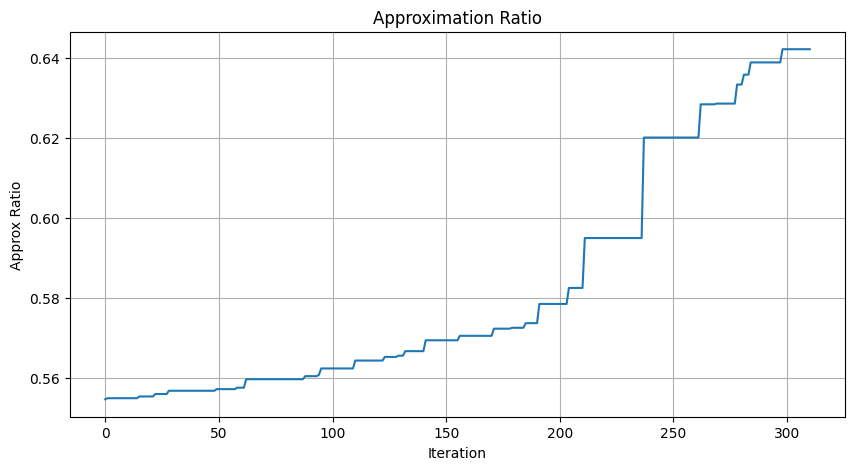

In [108]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))  # Set the size of the plot
plt.plot(df['iteration'], df['objective_value'], linestyle='-')
plt.title('Approximation Ratio')
plt.xlabel('Iteration')
plt.ylabel('Approx Ratio')
plt.grid(True)  # Add a grid for easier readability
plt.show()